<a href="https://colab.research.google.com/github/mihirsathe/ECE285FA18_BestGroup/blob/master/Keras_overhead_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install DataLoader
!pip install imageio
!pip install -q keras
#Mount google drive with dataset
from google.colab import drive
drive.mount('/content/drive')

# keras.backend.set_session

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-iktu7h6c
  Running setup.py bdist_wheel for keras-contrib ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ct4orxv3/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Running setup.py bdist_wheel for DataLoader ... - done
  Stored in directory: /root/.cache/pip/wheels/3a/a0/74/7190a79f983c5276ddcfe888612746a633d8ed0c0eaf7fa42d
Successfully built DataLoader
    100% |████████████████████████████████| 3.3MB 9.2MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A

In [0]:
# Super-resolution of CelebA using Generative Adversarial Networks.
# The dataset can be downloaded from: https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADIKlz8PR9zr6Y20qbkunrba/Img/img_align_celeba.zip?dl=0
# Instrustion on running the script:
# 1. Download the dataset from the provided link
# 2. Save the folder 'img_align_celeba' to 'datasets/'
# 4. Run the sript using command 'python srgan.py'


from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.applications import VGG19
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
# from google.col
import numpy as np
import os

import keras.backend as K
import glob

In [0]:
import numpy as np
import imageio
from keras.utils import Sequence
from os import listdir
from os.path import isfile, join
from skimage.transform import downscale_local_mean
import random
import tensorflow as tf


def normalize(image):
  return image/255.0    

def read_VEDAI(subset, PATH_TO_VEHICLES_FOLDER):
    # Takes in the full path to the unzipped "VEHICULES" folder
    # Returns mapping dict, RGB and Infrared images in 
    # (images, x, y, channels) format,
    # saves a txt file with mapping of rgb/infra idx to filename
    # NUM_FILES = 2536
    # MAX_INDEX = 1272
    X_PIXELS = 1024
    Y_PIXELS = 1024
    PATH_TO_VEHICLES_FOLDER = PATH_TO_VEHICLES_FOLDER[0]

    onlyfiles = [f for f in listdir(PATH_TO_VEHICLES_FOLDER) if isfile(
        join(PATH_TO_VEHICLES_FOLDER, f)) and "png" in f]
    # assert len(onlyfiles) == NUM_FILES, "Not the full VEDAI 1024 Dataset"
    rgb = np.zeros((len(subset), X_PIXELS, Y_PIXELS, 3))
    infra = np.zeros((len(subset), X_PIXELS, Y_PIXELS, 1))
    indices = subset

    print(indices)
    print(rgb.shape)
    index_filename_map = {}
    im_cnt = 0

    for index in indices:
        pair = [file for file in onlyfiles if str(index) in file]
        if pair:
            for file in pair:
                index_filename_map[im_cnt] = file.split('_')[0]
                im = imageio.imread(PATH_TO_VEHICLES_FOLDER + '/' + file)
                if "co" in file:
                    # print('Inserting RGB @ '+ str(im_cnt))
                    rgb[im_cnt, :, :, :] = np.reshape(
                        im, (tuple([1]) + im.shape))
                elif "ir" in file:
                    # print('Inserting Infra @ '+ str(im_cnt))
                    infra[im_cnt, :, :, :] = np.reshape(
                        im, (tuple([1]) + im.shape + tuple([1])))
            im_cnt = im_cnt + 1
        else:
            print("The following image is missing!: " + index)
    # print(index_filename_map)
    f = open(PATH_TO_VEHICLES_FOLDER + "_mapping.txt", "w")
    f.write(str(index_filename_map))
    f.close()
    return rgb, infra


def scan_dataset(PATH_TO_VEHICLES_FOLDER):
    # Takes in the full path to the unzipped "VEHICULES" folder
    # Returns a list of all the files
    # and saves a dataset summary text file with list of all file names
    MAX_INDEX = 10
    PATH_TO_VEHICLES_FOLDER = PATH_TO_VEHICLES_FOLDER[0]
    indices = [format(n, '08') for n in range(MAX_INDEX)]
    export_files = []

    onlyfiles = [f for f in listdir(PATH_TO_VEHICLES_FOLDER) if isfile(
        join(PATH_TO_VEHICLES_FOLDER, f)) and "png" in f]

    for index in indices:
        pair = [file for file in onlyfiles if str(index) in file]
        if pair:
            for file in pair:
                if "co" in file:
                    export_files.append(file.split('_')[0])
        else:
            print("The following image is missing!: " + index)
    np.savetxt(PATH_TO_VEHICLES_FOLDER + '_summary.txt',
               export_files, delimiter=" ", fmt="%s")
    return export_files


def create_subsets(imgs, output_path, use_validation=True,
                   training_percent=0.7, testing_percent=0.3, SEED=1):
    # Takes a list of image file names and shuffles
    # them before splitting them into required subsets
    # Saves txt files containing the names of the files
    # used in each subset, no return value
    assert training_percent + \
        testing_percent == 1, "Training + testing percents must equal 1."
    random.seed(SEED)
    random.shuffle(imgs)
    print('Using ' + str(len(imgs)) + ' images.')
    print('Saving files to ' + output_path)
    if not use_validation:
        training_imgs = imgs[:int(len(imgs) * training_percent)]
        testing_imgs = imgs[int(len(imgs) * training_percent):]
        np.savetxt(output_path + 'training.txt',
                   training_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'testing.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        return training_imgs, testing_imgs
    else:
        validation_split = 0.3  # use 30% of training dataset for validation
        training_imgs = imgs[int(len(imgs) * validation_split *
                                 training_percent):int(len(imgs) *
                                                       training_percent)]
        validation_imgs = imgs[:int(
            len(imgs) * validation_split * training_percent)]
        testing_imgs = imgs[int(len(imgs) * training_percent):]
        np.savetxt(output_path + 'validation.txt',
                   validation_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'training.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        np.savetxt(output_path + 'testing.txt',
                   testing_imgs, delimiter=" ", fmt="%s")
        return training_imgs, validation_imgs, testing_imgs


def save_VEDAI(rgb, infra):
    # Takes in arrays of rgb and infrared images
    # Saves them to disk, no return value
    np.save("vedai_rgb_all.npy", rgb)
    np.save("vedai_infra_all.npy", infra)


def load_VEDAI():
    # No parameters, expected to run in directory with VEDAI.npy files
    # Returns two arrays with rgb and infrared images respectively
    rgb = np.load("vedai_rgb_all.npy")
    infra = np.load("vedai_infra_all.npy")
    return rgb, infra


def data_explore(data):
    print("Shape of the data is" + str(data.shape))
    print("Dtype of the data is" + str(data.dtype))


def combine_rgb_infra(rgb, infra):
    # Concatenates the two modalities along the channels axis
    four_channel = np.concatenate((rgb, infra), axis=-1)
    return four_channel

  
def overlapping_patches(images, patch_size=(64, 64), padding="VALID"):
    sess = tf.Session()

    num_images, size_x, size_y, channels = images.shape
    ims = tf.convert_to_tensor(images)
    patch_x, patch_y = patch_size
    patches = tf.extract_image_patches(ims, [1, patch_x, patch_y, 1], [
        1, patch_x, patch_y, 1], [1, 1, 1, 1], padding=padding)
    patches_shape = tf.shape(patches)
    with sess.as_default():
        np = tf.reshape(patches, [tf.reduce_prod(patches_shape[0:3]),
                                  patch_x, patch_y, channels]).eval()
        return np  


def non_overlapping_patches(image, patch_size=(64, 64)):
    size_x, size_y, channels = image.shape
    patch_x, patch_y = patch_size
    im_pad = np.pad(image, ((0, patch_x - size_x % patch_x),
                            (0, patch_y - size_y % patch_y), (0, 0)),
                    mode="constant")
    if size_x % patch_x == 0 and size_y % patch_y == 0:
        im_pad = image
    pad_x, pad_y, channels = im_pad.shape
    print(im_pad.shape)
    num_patches = (pad_x // patch_x) * (pad_y // patch_y)
    patches = np.zeros((num_patches, patch_x, patch_y, channels))
    counter = 0
    for i in range((pad_x // patch_x)):
        for j in range((pad_y // patch_y)):
            x_s = i * patch_x
            y_s = j * patch_y
            patches[counter, :, :, :] = im_pad[x_s:x_s + patch_x,
                                               y_s:y_s + patch_y, :]
            counter += 1
    return patches


def downsample_image(image, block=(4, 4, 1)):
    # Downsamples numpy array image by factor
    # Returns  the downsampled copy
    return downscale_local_mean(image, block)


def reconstruct_patches(patches, image_size):
    # TODO: Create a function which reconstructs an image
    # when given patches created by non_overlapping_patches
    # Discards predictions for zero border
    pass


class VEDAISequence(Sequence):

    def __init__(self, rgb, infra, ims_per_batch):
        self.r, self.i = rgb, infra
        self.ims_per_batch = ims_per_batch

    def __len__(self):
        # Returns number of batches given training set and ims_per_batch
        return int(np.ceil(len(self.r) / float(self.ims_per_batch)))

    def __getitem__(self, idx):
        # Number of patches * ims_per_batch
        batchsz = 256 * self.ims_per_batch
        # RGB and infra
        channels = 4
        # Default patch size
        patch_x, patch_y = 64, 64

        # Batch number * ims_per_batch
        start = idx * self.ims_per_batch
        # Batch number * ims_per_batch  + 1
        end = (idx + 1) * self.ims_per_batch

        # Preallocate arrays of the correct size
        high_res = np.zeros((batchsz, patch_x, patch_y, channels))
        im_num = 0
        for ind in range(start, end):
            st, stp = im_num * 256, (im_num + 1) * 256
            im_num += 1
            rgb = imageio.imread(self.r[ind])
            infra = imageio.imread(self.i[ind])
            high_res[st:stp, :, :, :] = non_overlapping_patches(
                combine_rgb_infra(rgb, infra))
        low_res = np.asarray([downsample_image(patch) for patch in high_res])
        return low_res, high_res

The following image is missing!: 00000005
Using 9 images.
Saving files to ./drive/My Drive/ECE285_Proj/datasets/VEDAI/
Training files: ['00000006', '00000007', '00000008', '00000004', '00000003', '00000000']
Testing files: ['00000009', '00000001', '00000002']
['00000006', '00000007', '00000008', '00000004', '00000003', '00000000']
(6, 1024, 1024, 3)
RGB shape: (6, 1024, 1024, 3)
Infra shape: (6, 1024, 1024, 1)
Data shape: (6, 1024, 1024, 3)
Low res shape: (1536, 16, 16, 3)
Hi res - 
Shape of the data is (1536, 64, 64, 3)
Dtype of the data is float64
Max of data is 255.0
Min of data is 0.0
Lo res - 
Shape of the data is (1536, 16, 16, 3)
Dtype of the data is float64
Max of data is 294.43962201615756
Min of data is -12.197769298466836
(16, 16)


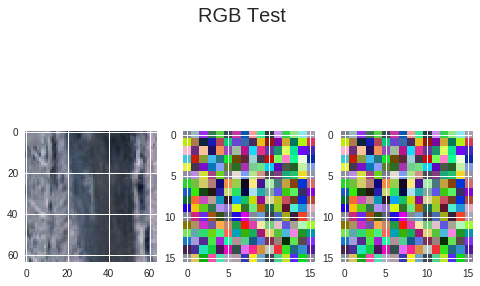

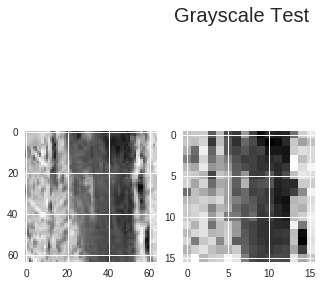

In [0]:
path = glob.glob('./drive/My Drive/ECE285_Proj/datasets/VEDAI/*')
files = scan_dataset(path)
training_set, testing_set = create_subsets(files,'./drive/My Drive/ECE285_Proj/datasets/VEDAI/', use_validation = False)

print('Training files: ' + str(training_set))
print('Testing files: ' + str(testing_set))

rgb, infra = read_VEDAI(training_set, path)
print('RGB shape: '+ str(rgb.shape))
print('Infra shape: '+ str(infra.shape))

training_data = combine_rgb_infra(rgb, infra)
# training_data=rgb
print('Data shape: '+ str(training_data.shape))

training_data = normalize(training_data)

data_patched = overlapping_patches(training_data)
patch_size = data_patched.shape[1]
down_patch_size = int(patch_size/4)
print("Patch size " + str(down_patch_size))

im_hr = np.zeros(data_patched.shape)
im_lr = np.zeros(data_patched.shape)
im_lr = im_lr[:,0:down_patch_size,0:down_patch_size,:]

print('Low res shape: ' + str(im_lr.shape))

factor = 4
patch_size = data_patched.shape[1]
down_patch_size = int(patch_size/factor)

for image in range(data_patched.shape[0]):
  im_lr[image,:,:,:] = downsample_image(data_patched[image,:,:,:])

print("Hi res - ")
data_explore(data_patched)
print("Lo res - ")
data_explore(im_lr)

plt.figure().suptitle('RGB+Infra', fontsize=20)
plt.subplot(1,2,1)
plt.imshow(data_patched[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(im_lr[0,:,:,:])

In [0]:

class SRGAN():
    def __init__(self):
        # Input shape
        self.channels = 3                  # RGB & Infra
        self.lr_height = 16                 # Low resolution height
        self.lr_width = 16                 # Low resolution width
        self.lr_shape = (self.lr_height, self.lr_width, self.channels)
        self.hr_height = self.lr_height*4   # High resolution height
        self.hr_width = self.lr_width*4     # High resolution width
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        path = glob.glob('./drive/My Drive/ECE285_Proj/datasets/VEDAI/*')
        rgb, infra = create_VEDAI(path)
        data_patched = overlapping_patches(rgb)
        patch_size = data_patched.shape[1]
        down_patch_size = int(patch_size/4)

        self.im_hrs = np.zeros(data_patched.shape)
        self.im_lrs = np.zeros(data_patched.shape)
        self.im_lrs = self.im_lrs[:,0:down_patch_size,0:down_patch_size,:]

        for image in range(data_patched.shape[0]):
          self.im_hrs[image,:,:,:], self.im_lrs[image,:,:,:] = downsample_image(data_patched[image,:,:,:])

        # Number of residual blocks in the generator
        self.n_residual_blocks = 16

        optimizer = Adam(0.0002, 0.5)

        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.vgg = self.build_vgg()
        self.vgg.trainable = False
        self.vgg.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Calculate output shape of D (PatchGAN)
        patch = int(self.hr_height / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 16
        self.df = 16

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        
        #Configure data loader
        self.dataset_name = 'VEDAI'
        # self.data_loader = im_hr, im_lr
#         print("im_hr shape is " + self.im_hr.shape)

        # Build the generator
        self.generator = self.build_generator()

        # High res. and low res. images
        img_hr = Input(shape=self.hr_shape)
        img_lr = Input(shape=self.lr_shape)

        # Generate high res. version from low res.
        fake_hr = self.generator(img_lr)

        # Extract image features of the generated img
        fake_features = self.vgg(fake_hr)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminator determines validity of generated high res. images
        validity = self.discriminator(fake_hr)

        self.combined = Model([img_lr, img_hr], [validity, fake_features])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1],
                              optimizer=optimizer)


    def build_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        vgg = VGG19(weights='imagenet')
        # Set outputs to outputs of last conv. layer in block 3
        # See architecture at: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
        vgg.outputs = [vgg.layers[9].output]

        img = Input(shape=self.hr_shape)
       

        # Extract image features
        img_features = vgg(img)
         
#         model = Model(img, img_features)
#         tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#           model,
#           strategy=tf.contrib.tpu.TPUDistributionStrategy(
#             tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
#         return tpu_model
        return Model(img, img_features)

    def build_generator(self):
    
        def residual_block(layer_input, filters):
            """Residual block described in paper"""
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
            u = Activation('relu')(u)
            return u

        # Low resolution image input
        img_lr = Input(shape=self.lr_shape)

        # Pre-residual block
        c1 = Conv2D(16, kernel_size=9, strides=1, padding='same')(img_lr)
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(16, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        u1 = deconv2d(c2)
        u2 = deconv2d(u1)

        # Generate high resolution output
        gen_hr = Conv2D(self.channels, kernel_size=9, strides=1, padding='same', activation='tanh')(u2)

        return Model(img_lr, gen_hr)

    def build_discriminator(self):

        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        # Input img
        d0 = Input(shape=self.hr_shape)

        d1 = d_block(d0, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)

        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        validity = Dense(1, activation='sigmoid')(d10)

        return Model(d0, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        for epoch in range(epochs):

            # ----------------------
            #  Train Discriminator
            # ----------------------

            # Sample images and their conditioning counterparts
            # imgs_hr, imgs_lr = self.data_loader
            imgs_hr = self.im_hrs[0,:,:,:]
            imgs_lr = self.im_lrs[0,:,:,:]
            
            imgs_hr = imgs_hr[np.newaxis,...]
            imgs_lr = imgs_lr[np.newaxis,...]

            # From low res. image generate high res. version
            fake_hr = self.generator.predict(imgs_lr)

            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)

            # Train the discriminators (original images = real / generated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_hr, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_hr, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            # Sample images and their conditioning counterparts
#             imgs_hr, imgs_lr = self.data_loader
            imgs_hr = self.im_hrs[0,:,:,:]
            imgs_lr = self.im_lrs[0,:,:,:]
    
            imgs_hr = imgs_hr[np.newaxis,...]
            imgs_lr = imgs_lr[np.newaxis,...]

    
            # The generators want the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)

            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(imgs_hr)

            # Train the generators
            g_loss = self.combined.train_on_batch([imgs_lr, imgs_hr], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time
            # Plot the progress
            print ("%d time: %s" % (epoch, elapsed_time))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        os.makedirs('./drive/My Drive/ECE285_Proj/images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 2

        imgs_hr = self.im_hrs[np.newaxis,...]
        imgs_lr = self.im_lrs[np.newaxis,...]
        
#         imgs_hr, imgs_lr = self.data_loader
        fake_hr = self.generator.predict(imgs_lr)

        # Rescale images 0 - 1
        imgs_lr = 0.5 * imgs_lr + 0.5
        fake_hr = 0.5 * fake_hr + 0.5
        imgs_hr = 0.5 * imgs_hr + 0.5

        # Save generated images and the high resolution originals
        titles = ['Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for row in range(r):
            for col, image in enumerate([fake_hr, imgs_hr]):
                axs[row, col].imshow(image[row])
                axs[row, col].set_title(titles[col])
                axs[row, col].axis('off')
            cnt += 1
        fig.savefig("./drive/My Drive/ECE285_Proj/images/%s%d.png" % (self.dataset_name, epoch))
        plt.close()

        # Save low resolution images for comparison
        for i in range(r):
            fig = plt.figure()
            plt.imshow(imgs_lr[i])
            fig.savefig('./drive/My Drive/ECE285_Proj/images/%s/%d_lowres%d.png' % (self.dataset_name, epoch, i))
            plt.close()

if __name__ == '__main__':
    gan = SRGAN()
    gan.train(epochs=3000, batch_size=1, sample_interval=5)
#     gan.train(epochs=300, batch_size=1, sample_interval=50)

The following image is missing!: 00000005


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 time: 0:00:44.511796


ValueError: ignored